In [1]:
%load_ext autoreload
%autoreload 2 
import pandas as pd
import numpy as np
import requests 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import json
import scipy.stats as stats
import seaborn as sns

In [2]:
# from data_compilation import call_all_symbols
# from data_cleaning import full_clean

In [3]:
# symbol_list = ['SLV', 'SIL', 'GLD', 'GDX', 'DJI']

In [4]:
# df = call_all_symbols(symbol_list)

In [5]:
from data_cleaning import full_clean

In [6]:
#Cleaning data
df_clean = full_clean()

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


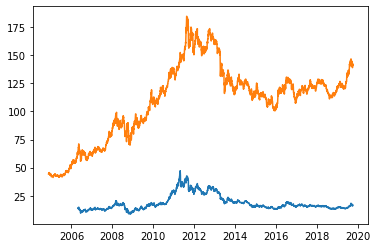

In [7]:
df_clean_SLV = df_clean.loc[df_clean['symbol'] == 'SLV']
df_clean_GLD = df_clean.loc[df_clean['symbol'] == 'GLD']
plt.plot(df_clean_SLV['date'], df_clean_SLV['close'])
plt.plot(df_clean_GLD['date'], df_clean_GLD['close']);

In [8]:
df_clean['daily_movement'] = (df_clean.close-df_clean.open)*100/df_clean.open
df_clean.head()

,date,open,high,low,close,volume,symbol,daily_movement
0,2019-10-08,16.60,16.66,16.49,16.61,19326217.0,SLV,0.060241
1,2019-10-07,16.38,16.46,16.28,16.30,8359926.0,SLV,-0.488400
2,2019-10-04,16.30,16.46,16.25,16.41,17200800.0,SLV,0.674847
3,2019-10-03,16.38,16.65,16.37,16.43,24412700.0,SLV,0.305250
4,2019-10-02,16.33,16.54,16.27,16.43,21300800.0,SLV,0.612370


In [9]:
df_clean_SLV = df_clean.loc[df_clean['symbol'] == 'SLV'][['date','symbol','open','close','daily_movement']]
df_clean_GLD = df_clean.loc[df_clean['symbol'] == 'GLD'][['date','symbol','open','close','daily_movement']]
df_clean_GLD.date.isin(df_clean_SLV.date).value_counts()

True     3385
False     362
Name: date, dtype: int64

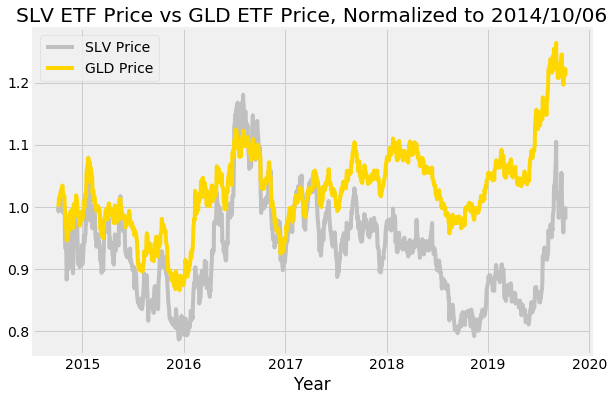

In [10]:
#Normalized to 2014-10-06
SLV_scaled = df_clean_SLV.loc[df_clean_SLV.date>='2014-10-06'].copy()
GLD_scaled = df_clean_GLD.loc[df_clean_GLD.date>='2014-10-06'].copy()

SLV_scaled['scale'] = SLV_scaled['close']/SLV_scaled.iloc[-1]['close']
GLD_scaled['scale'] = GLD_scaled['close']/GLD_scaled.iloc[-1]['close']

SLV_scaled['pct_change'] = SLV_scaled.close.pct_change()*100
GLD_scaled['pct_change'] = GLD_scaled.close.pct_change()*100
SLV_scaled = SLV_scaled.fillna(value=0)
GLD_scaled = GLD_scaled.fillna(value=0)

plt.figure(figsize = (10,6))
plt.style.use('fivethirtyeight')
plt.plot(SLV_scaled['date'], SLV_scaled['scale'],label='SLV Price',c='silver')
plt.plot(GLD_scaled['date'], GLD_scaled['scale'],label='GLD Price',c='gold')
plt.title("SLV ETF Price vs GLD ETF Price, Normalized to 2014/10/06")
plt.xlabel('Year')
plt.legend()

plt.savefig('img/SLV_vs_GLD_5yrs')


### Comparing daily movements : SLV vs GLD
#### $H{0}$: daily_movement_SLV - daily_movement_GLD = 0
#### $H{a}$: daily_movement_SLV - daily_movement_GLD > 0

In [11]:
from  hypothesis_tests import *

In [12]:
a_day,b_day = hypothesis_test_three_prep(df_clean, type = 'day')

In [13]:
len(a_day)

1191

NormaltestResult(statistic=11.830310725125782, pvalue=0.002698240560717545)


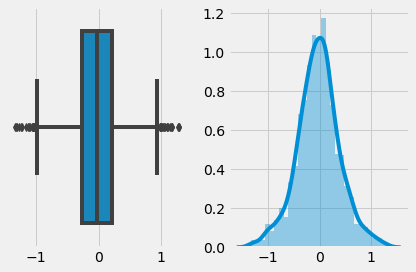

In [14]:
day_movement_diff = a_day-b_day
print(stats.normaltest(day_movement_diff))
fig,ax = plt.subplots(1,2, tight_layout=True)
sns.boxplot(day_movement_diff,ax=ax[0])
sns.distplot(day_movement_diff,ax=ax[1]);

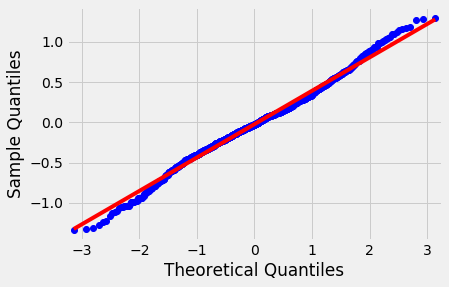

In [15]:
sm.qqplot(day_movement_diff, line = 'r');

In [16]:
hypothesis_test_three_pttest(a_day,b_day)

t_val = -1.9648175958409035, p_val = 0.049667723760604535
Based on the p value of 0.049667723760604535 and our alpha of 0.05 we reject  the null hypothesis.
Due to these results, we  can state that there is a difference between daily movement of SLV and GLD
with an effect size, cohen's d, of -0.04317969946956076.


'Reject'

In [17]:
x_bar_dy = day_movement_diff.mean()
Sdiff_dy = day_movement_diff.std()
dof = len(day_movement_diff)-1
t_dy = (x_bar_dy - 0)/(Sdiff_dy/np.sqrt(len(day_movement_diff)))

print(f"x_bar:{x_bar_dy}\n sample_std:{Sdiff_dy}\n t-score:{t_dy}")

x_bar:-0.02356579272696338
 sample_std:0.4139193176934802
 t-score:-1.9648175958409027


In [18]:
tscore = (stats.t.ppf(1-0.05, dof))
rangemin_dy = x_bar_dy - (tscore * (Sdiff_dy/np.sqrt(len(day_movement_diff))))
rangemax_dy = x_bar_dy + (tscore * (Sdiff_dy/np.sqrt(len(day_movement_diff))))

print(f"confidence interval = {round(rangemin_dy,2)} - {round(rangemax_dy,2)}")

confidence interval = -0.04 - -0.0


In [19]:
import statsmodels.stats.power as smp

In [20]:
spooled_S_day = np.sqrt(((a_day.std()**2 + b_day.std()**2)/2))
coh_d_day = (a_day.mean() - b_day.mean()) / spooled_S_day
power = smp.ttest_power(coh_d_day, nobs=len(day_movement_diff), alpha=0.05, alternative='two-sided')
print(f"effect size = {coh_d_day}, power = {power}")

effect size = -0.04317969946956076, power = 0.31910261785300686


## Looking at weekly movement

### $𝐻{0} $ : weekly movement SLV  - weekly movement  GLD = 0 
### $𝐻{a} $ : weekly movement SLV  - weekly movement GLD > 0 


In [21]:
a_wk,b_wk = hypothesis_test_three_prep(df_clean, type = 'week')

NormaltestResult(statistic=4.550932784061386, pvalue=0.10274897595494453)


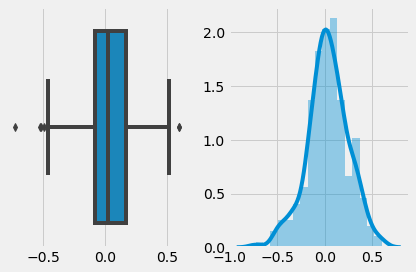

In [22]:
week_movement_diff = a_wk-b_wk
print(stats.normaltest(week_movement_diff))
fig,ax = plt.subplots(1,2, tight_layout=True)
sns.boxplot(week_movement_diff,ax=ax[0])
sns.distplot(week_movement_diff,ax=ax[1]);

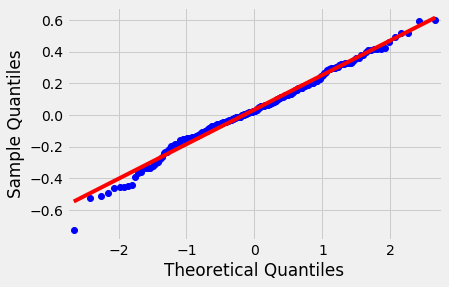

In [23]:
sm.qqplot(week_movement_diff, line = 'r');

In [24]:
hypothesis_test_three_pttest(a_wk,b_wk)

t_val = 2.5658606391187773, p_val = 0.01087117741096053
Based on the p value of 0.01087117741096053 and our alpha of 0.05 we reject  the null hypothesis.
Due to these results, we  can state that there is a difference between daily movement of SLV and GLD
with an effect size, cohen's d, of 0.13159009809366198.


'Reject'

In [25]:
x_bar_wk = week_movement_diff.mean()
Sdiff_wk = week_movement_diff.std()
dof = len(week_movement_diff)-1
t_wk = (x_bar_wk - 0)/(Sdiff_wk/np.sqrt(len(week_movement_diff)))

print(f"x_bar:{x_bar_wk}\n sample_std:{Sdiff_wk}\n t-score:{t_wk}")

x_bar:0.03486159200862652
 sample_std:0.21610977536857784
 t-score:2.5658606391187773


In [26]:
tscore = (stats.t.ppf(1-0.05, dof))
rangemin_wk = x_bar_wk - (tscore * (Sdiff_wk/np.sqrt(len(week_movement_diff))))
rangemax_wk = x_bar_wk + (tscore * (Sdiff_wk/np.sqrt(len(week_movement_diff))))

print(f"confidence interval = {round(rangemin_wk,2)} - {round(rangemax_wk,2)}")

confidence interval = 0.01 - 0.06


In [27]:
spooled_S_wk = np.sqrt(((a_wk.std()**2 + b_wk.std()**2)/2))
coh_d_wk = (a_wk.mean() - b_wk.mean()) / spooled_S_wk
power_wk = smp.ttest_power(coh_d_wk, nobs=len(week_movement_diff), alpha=0.05, alternative='larger')
print(f"effect size = {coh_d_wk}, power = {power_wk}")

effect size = 0.13159009809366198, power = 0.6709693184710062


## Looking at monthly movement

### $𝐻{0} $ : monthly movement SLV  - monthly movement  GLD = 0 
### $𝐻{a} $ : monthly movement SLV  - monthly movement GLD > 0 


In [28]:
a_mo,b_mo = hypothesis_test_three_prep(df_clean, type = 'month')

NormaltestResult(statistic=1.2749094451239094, pvalue=0.5286362390187018)


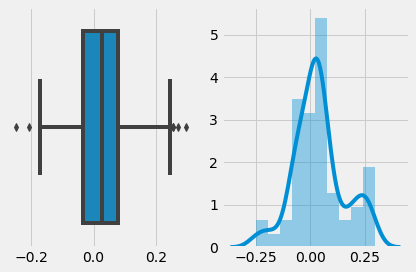

In [41]:
mo_movement_diff = a_mo-b_mo
print(stats.normaltest(mo_movement_diff))
fig,ax = plt.subplots(1,2, tight_layout=True)
sns.boxplot(mo_movement_diff,ax=ax[0])
sns.distplot(mo_movement_diff,ax=ax[1]);

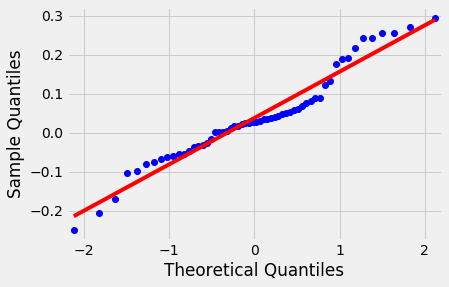

In [30]:
sm.qqplot(mo_movement_diff, line = 'r');

In [39]:
hypothesis_test_three_pttest(a_mo,b_mo)

t_val = 2.4915876536731583, p_val = 0.015651323079093372
Based on the p value of 0.015651323079093372 and our alpha of 0.05 we reject  the null hypothesis.
Due to these results, we  can state that there is a difference between daily movement of SLV and GLD
with an effect size, cohen's d, of 0.24848276295835892.


'Reject'

In [40]:
x_bar_mo = mo_movement_diff.mean()
Sdiff_mo = mo_movement_diff.std()
dof_mo = len(mo_movement_diff)-1
t_mo = (x_bar_mo - 0)/(Sdiff_mo/np.sqrt(len(mo_movement_diff)))

print(x_bar_mo,Sdiff_mo,t_mo)

0.03776918437556407 0.11544508104051174 2.491587653673158


In [33]:
tscore = (stats.t.ppf(1-0.05, dof))
rangemin_mo = x_bar_mo - (tscore * (Sdiff_mo/np.sqrt(len(mo_movement_diff))))
rangemax_mo = x_bar_mo + (tscore * (Sdiff_mo/np.sqrt(len(mo_movement_diff))))

print(f"confidence interval = {round(rangemin_mo,2)} - {round(rangemax_mo,2)}")

confidence interval = 0.01 - 0.06


In [34]:
spooled_S_mo = np.sqrt(((a_mo.std()**2 + b_mo.std()**2)/2))
coh_d_mo = (a_mo .mean() - b_mo .mean()) / spooled_S_mo 
power_mo  = smp.ttest_power(coh_d_mo , nobs=len(mo_movement_diff), alpha=0.05, alternative='larger')
print(f"effect size = {coh_d_mo }, power = {power_mo }")

effect size = 0.24848276295835892, power = 0.5890111853807549


### Misc Visualization


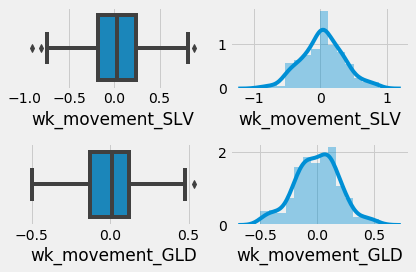

In [35]:
fig,ax = plt.subplots(2,2, tight_layout=True)
sns.boxplot(a_wk,ax=ax[0,0])
sns.distplot(a_wk,ax=ax[0,1],label='silver')
sns.boxplot(b_wk,ax=ax[1,0])
sns.distplot(b_wk,ax=ax[1,1],label='gold')
plt.show();

In [38]:
print(f"SLV: {stats.normaltest(a_wk)}")
print(f"GLD: {stats.normaltest(b_wk)}")

SLV: NormaltestResult(statistic=0.35711688070433184, pvalue=0.8364751715453652)
GLD: NormaltestResult(statistic=0.3744692573098545, pvalue=0.8292491479461026)
